In [73]:

# coding: utf-8

# In[80]:


import pandas as pd
from sodapy import Socrata
import numpy as np 
import ast
import json

CommunityToPoliceDistrict = []
with open('PoliceDistrictToCommunityNamesOutput.txt') as fp:
    for line in fp:
        communityNum, communityName, policeDist  = line.strip().split(":")
        communityName = communityName.strip()
        CommunityToPoliceDistrict.append({"Community_Area": float(communityNum), "Community_Name": communityName,
                                         "Police_District": policeDist})

CommunityPoliceDistrictDF = pd.DataFrame(CommunityToPoliceDistrict)
CommunityPoliceDistrictDF.head()

Community_Area  Community_Name Police_District
0             1.0     ROGERS PARK              24
1             2.0      WEST RIDGE              24
2             3.0          UPTOWN              23
3             4.0  LINCOLN SQUARE              20
4             5.0    NORTH CENTER              19

In [74]:

# In[81]:


CrimeData = pd.read_csv("Crimes2001_2020.csv",
                       dtype={'ID': int, 'Case Number' : str, 'Date' : str, 'Block' : str, 
                             'IUCR' : str, 'Primary Type' : str, 'Description' : str, 
                             'Location Description' : str, 'Arrest' : str, 'Domestic' : str, 'Beat' : str, 
                             'District' : float, 'Ward' : float, 'Community Area' : float, 'FBI Code' : str, 
                              'X Coordinate' : str, 'Y Coordinate' : str, 'Year' : int,'Updated On' : str,
                             'Latitude' : str, 'Longitude' : str, 'Location' : str}, )

CrimeData.rename(columns = {'Community Area':'Community_Area'}, inplace = True)
CrimeData = CrimeData.drop(['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'], axis = 1)
SampledCrimeData = CrimeData
SampledCrimeData = SampledCrimeData.join(CommunityPoliceDistrictDF.set_index('Community_Area'), on='Community_Area')
print(SampledCrimeData.head())
print(SampledCrimeData.columns)

         ID Case Number                    Date                 Block  IUCR  \
0  11034701    JA366925  01/01/2001 11:00:00 AM       016XX E 86TH PL  1153   
1  11227287    JB147188  10/08/2017 03:00:00 AM    092XX S RACINE AVE   281   
2  11227583    JB147595  03/28/2017 02:00:00 PM       026XX W 79TH ST   620   
3  11227293    JB147230  09/09/2017 08:17:00 PM  060XX S EBERHART AVE   810   
4  11227634    JB147599  08/26/2017 10:00:00 AM   001XX W RANDOLPH ST   281   

          Primary Type                          Description  \
0   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
1  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   
2             BURGLARY                       UNLAWFUL ENTRY   
3                THEFT                            OVER $500   
4  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   

  Location Description Arrest Domestic  Beat  District  Ward  Community_Area  \
0            RESIDENCE  FALSE    FALSE   412       4.0   8.0      

In [75]:
# In[82]:


# Used to Extract the data from the Socio Economic CSV File 
# To train our program what specific communities are better or worse off than average
import pandas as pd 
import numpy as np 

# We can use .describe() to find the benchmark levels of poverty per community. Compare community to the average and give weightage 
columns = [
'Community_Area',
'community_area_name', 
'%_housing_crowded', 
'%_households_below_poverty', 
'%_age16_unemployed',
'%_age25_nohighschool',
'%_not_working_age',
'per_capita_income',
'hardship_index']

SocioeconomicData = pd.read_csv("SocioeconomicData.csv")
SocioeconomicData.columns = columns

SampledCrimeData = SampledCrimeData.join(SocioeconomicData.set_index('Community_Area'), on='Community_Area')

print(SampledCrimeData.columns)

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community_Area', 'FBI Code', 'Year', 'Updated On',
       'Community_Name', 'Police_District', 'community_area_name',
       '%_housing_crowded', '%_households_below_poverty', '%_age16_unemployed',
       '%_age25_nohighschool', '%_not_working_age', 'per_capita_income',
       'hardship_index'],
      dtype='object')


In [76]:
# In[83]:


import pandas as pd

census = pd.read_csv("census_data.csv", header=1)

CensusData = pd.DataFrame(census)
CensusData = CensusData[CensusData.columns[range(67)]]
CensusData = CensusData.rename(columns={"Geog": "Community_Name", "GeogKey": "Community_Area"})

SampledCrimeData = SampledCrimeData.merge(CensusData, on='Community_Area', how='left')
SampledCrimeData = SampledCrimeData.drop(
    ['Arrest', 'Domestic', 'FBI Code', 'IUCR', 'Beat', 'Ward',
    'Case Number', 'Block', 'Primary Type', 'Description','Location Description', 'District', 'Community_Area', 'Year',
       'Updated On', 'community_area_name', 'Police_District','Not Hispanic or Latino, American Indian and Alaska Native alone','Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone', 
     'Not Hispanic or Latino, Some Other Race alone','Not Hispanic or Latino, Two or More Races'], axis = 1)

SampledCrimeData = SampledCrimeData.dropna()
SampledCrimeData.rename(columns={'Not Hispanic or Latino, White alone' : '#_White',
       'Not Hispanic or Latino, Black or African American alone' : "#_African_American",
       'Not Hispanic or Latino, Asian alone' : "#_Asian",'Hispanic or Latino' : "#_Hispanic"}, inplace = True)


In [77]:
# In[84]:


from datetime import datetime, time
morningStart = time(6, 0, 0)
morningEnd = time(12,0,0)
afternoonStart = time(12,0,1)
afternoonEnd = time(18,30,0)
nightStart = time(18,31,0)
nightEnd = time(23,59,59)
midnightStart = time(0,0,0)
midnightEnd = time(5,59,0)

# Time of Day Function
def timeOfDayApplier(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
    
    if morningStart <= DatetimeVersion.time() <= morningEnd:
        return "Morning"
    elif afternoonStart <= DatetimeVersion.time() <= afternoonEnd:
        return "Afternoon/Evening"
    elif nightStart <= DatetimeVersion.time() <= nightEnd:
        return "Night"
    elif midnightStart <= DatetimeVersion.time() <= midnightEnd:
        return "Midnight"

SampledCrimeData['TimeOfDay'] = SampledCrimeData['Date'].map(timeOfDayApplier)


In [78]:
# In[85]:


from datetime import datetime, time
springStart = 3
springEnd = 5
summerStart = 6
summerEnd = 8
fallStart = 9
fallEnd = 11
winterStart = 12
winterEnd = 2 
# Time of Day Function
def seasonOfYear(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.month in [12,1,2]:
        return "Winter"   
    elif springStart <= DatetimeVersion.month <= springEnd:
        return "Spring"
    elif summerStart <= DatetimeVersion.month <= summerEnd:
        return "Summer"
    elif fallStart <= DatetimeVersion.month <= fallEnd:
        return "Fall"

SampledCrimeData['Season'] = SampledCrimeData['Date'].map(seasonOfYear)

# Time of Day Function
def dayOfWeek(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.weekday() in [0,1,2,3,4]:
        return "Weekday"   
    else:
        return "Weekend"

SampledCrimeData['Weekday/Weekend'] = SampledCrimeData['Date'].map(dayOfWeek)


# In[86]:


print(SampledCrimeData['Date'][0]) # value check 
print(SampledCrimeData['TimeOfDay'][0]) # value check
print(SampledCrimeData['Season'][0]) # value check
print(SampledCrimeData['Weekday/Weekend'][0]) # value check


01/01/2001 11:00:00 AM
Morning
Winter
Weekday


In [79]:
# In[87]:


print("Columns: ", SampledCrimeData.columns)
print(SampledCrimeData.head())
print("Shape: ", SampledCrimeData.shape)

Columns:  Index(['ID', 'Date', 'Community_Name_x', '%_housing_crowded',
       '%_households_below_poverty', '%_age16_unemployed',
       '%_age25_nohighschool', '%_not_working_age', 'per_capita_income',
       'hardship_index', 'Community_Name_y', 'Total Population', '#_White',
       '#_African_American', '#_Asian', '#_Hispanic',
       'Male: Under 5 years old', 'Male: 5 to 9 years', 'Male: 10 to 14 years',
       'Male: 15 to 17 years', 'Male: 18 and 19 years', 'Male: 20 years',
       'Male: 21 years', 'Male: 22 to 24 years', 'Male: 25 to 29 years',
       'Male: 30 to 34 years', 'Male: 35 to 39 years', 'Male: 40 to 44 years',
       'Male: 45 to 49 years', 'Male: 50 to 54 years', 'Male: 55 to 59 years',
       'Male: 60 and 61 years', 'Male: 62 to 64 years',
       'Male: 65 and 66 years', 'Male: 67 to 69 years', 'Male: 70 to 74 years',
       'Male: 75 to 79 years', 'Male: 80 to 84 years',
       'Male: 85 years and over', 'Female: Under 5 years old',
       'Female: 5 to 9 year

In [80]:
SampledCrimeData = SampledCrimeData.drop(['Community_Name_y'], axis = 1)
SampledCrimeData.rename(columns = {'Community_Name_x':'Community_Name', '%_housing_crowded':'percent_housing_crowded',
                                   '%_households_below_poverty': 'percent_households_below_poverty',
                                   '%_age16_unemployed' : 'percent_age16_unemployed',
                                   '%_age25_nohighschool' : 'percent_age25_nohighschool'}, inplace = True)


In [81]:
import pandasql
query = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    , COUNT(*) AS crimes
    ,percent_age16_unemployed
    FROM SampledCrimeData
    GROUP BY Community_Name
)
SELECT 
cr.Community_Name
,cr.crimes as Num_Crimes
,cr.percent_age16_unemployed
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""
NumCrimes_HousingCrowded = pandasql.sqldf(query, globals())
print(NumCrimes_HousingCrowded)
print("# CRIMES TOTAL: ",sum(NumCrimes_HousingCrowded.Num_Crimes))

            Community_Name  Num_Crimes  percent_age16_unemployed
0                   AUSTIN         517                      22.6
1          NEAR NORTH SIDE         338                       7.0
2           NEAR WEST SIDE         321                      10.7
3                WEST TOWN         287                       6.6
4            HUMBOLDT PARK         275                      17.3
5           NORTH LAWNDALE         237                      21.2
6              SOUTH SHORE         217                      20.0
7                     LOOP         203                       5.7
8                LAKE VIEW         191                       4.7
9             LOGAN SQUARE         179                       8.2
10          AUBURN GRESHAM         177                      28.3
11               ENGLEWOOD         176                      28.0
12                ROSELAND         175                      20.3
13                NEW CITY         174                      23.0
14  GREATER GRAND CROSSIN

<IPython.core.display.Javascript object>


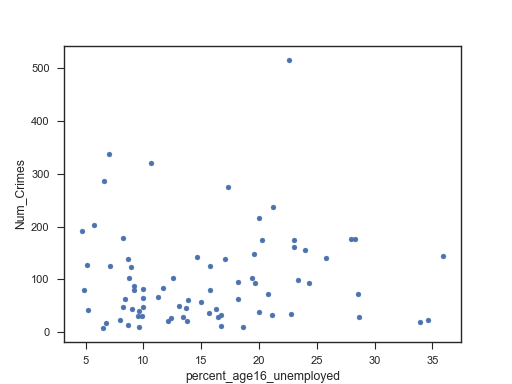

In [82]:
NumCrimes_HousingCrowded.plot.scatter(x='percent_age16_unemployed',
                      y='Num_Crimes')

In [83]:
NumCrimes_HousingCrowded.corr()

Num_Crimes  percent_age16_unemployed
Num_Crimes                  1.000000                  0.070533
percent_age16_unemployed    0.070533                  1.000000